In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

sys.path.append('../')
from ImitationLearner import ImitationLearner, evaluate_performance

In [3]:
results_dir = 'offline_results_TMY3'

if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
weights_dir = os.path.join(results_dir, 'weights')
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [4]:
imit_results = results_dir + "/Imit_{}.pkl"
f_weights = results_dir + "/weights/F-{}.npy"
bd_weights = results_dir + "/weights/Bd-{}.npy"
loss_fname = results_dir + "/Imit_loss.pkl"

#### Specify the names of state, control and target variables

In [5]:
# Modify here: Outputs from EnergyPlus; Match the variables.cfg file.
obs_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Htg SP", "Clg SP", "Indoor Temp.", "Indoor Temp. Setpoint", "PPD", "Occupancy Flag", "Coil Power", "HVAC Power", "Sys In Temp.", "Sys In Mdot", "OA Temp.", "OA Mdot", "MA Temp.", "MA Mdot", "Sys Out Temp.", "Sys Out Mdot"]

# Modify here: Change based on the specific control problem
state_name = ["Indoor Temp."]
dist_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Occupancy Flag"]
# Caveat: The RL agent controls the difference between Supply Air Temp. and Mixed Air Temp., i.e. the amount of heating from the heating coil. But, the E+ expects Supply Air Temp. Setpoint.
ctrl_name = ["Delta T"]
target_name = ["Indoor Temp. Setpoint"]

#### Load data

In [6]:
# Read Historical Data
dataset = pd.read_pickle("simulation_results/Sim-TMY3.pkl")
dataset.index[1:]

DatetimeIndex(['1991-01-01 00:15:00', '1991-01-01 00:30:00',
               '1991-01-01 00:45:00', '1991-01-01 01:00:00',
               '1991-01-01 01:15:00', '1991-01-01 01:30:00',
               '1991-01-01 01:45:00', '1991-01-01 02:00:00',
               '1991-01-01 02:15:00', '1991-01-01 02:30:00',
               ...
               '1991-04-01 21:45:00', '1991-04-01 22:00:00',
               '1991-04-01 22:15:00', '1991-04-01 22:30:00',
               '1991-04-01 22:45:00', '1991-04-01 23:00:00',
               '1991-04-01 23:15:00', '1991-04-01 23:30:00',
               '1991-04-01 23:45:00', '1991-04-02 00:00:00'],
              dtype='datetime64[ns]', length=8736, freq=None)

In [7]:
target = dataset[target_name]
disturbance = dataset[dist_name]
# Min-Max Normalization
disturbance = (disturbance-disturbance.min())/(disturbance.max()-disturbance.min())

dataset["Delta T"] = dataset["Sys Out Temp."]-dataset["MA Temp."]

# Train-Test Split
n_samples = len(dataset)
n_train = int(0.7*n_samples)
n_test = n_samples - n_train
train_set = dataset[:n_train]
test_set = dataset[n_train:]

#### Specify hyperparameters

In [8]:
# Training Hyperparams
epochs = 20
step   = 900   # 15 minutes
bs     = 256   # batch size 
lr     = 5e-4  # learning rate

# MPC Hyperparams
u_upper = 5
u_lower = 0

n_state = len(state_name)    # State variables
n_ctrl  = len(ctrl_name)      # The variable that the RL agent controls
n_dist  = len(dist_name)      # Disturbance variables 

#### Define the training loop

In [9]:
def train():
    # x is state and u is action
    # true is the expert (EPlus) and pred is the learner
    x_true = []
    u_true = []
    x_pred = []
    u_pred = []

    # the loss function includes diff between both state and actions
    train_state_loss = []
    train_action_loss = []
    for i in range(n_train): # By number of entries in the historical data
        idx = np.random.randint(n_train)
        cur_time = train_set.index[idx]

        expert_moves = train_set[cur_time:cur_time+pd.Timedelta(seconds = step)]
        if len(expert_moves)<2:
            print(cur_time)
            continue

        expert_state = torch.tensor(expert_moves[state_name].values).reshape(-1, n_state) # 2 x n_state
        expert_action = torch.tensor(expert_moves[ctrl_name].values).reshape(-1, n_ctrl) # 2 x n_ctrl
        x_true.append(expert_state[-1])
        u_true.append(expert_action[0])

        obs = train_set.loc[cur_time]
        x_init = torch.tensor(np.array([obs[name] for name in state_name])).unsqueeze(0) # n_batch x n_state, i.e. 1 x n_state
        C, c = learner.Cost_function(cur_time)
        learner_state, learner_action = learner.forward(x_init, C, c, cur_time)

        # Predict next state based on expert's action
        next_state = learner.predict(x_init.squeeze(0), expert_action[0], cur_time)
        x_pred.append(next_state)
        u_pred.append(learner_action)

        if (i % bs == 0) & (i>0):
            x_true = torch.stack(x_true).reshape(-1, n_state)
            u_true = torch.stack(u_true).reshape(-1, n_ctrl)
            x_pred = torch.stack(x_pred).reshape(-1, n_state)
            u_pred = torch.stack(u_pred).reshape(-1, n_ctrl)
            b_state_loss, b_action_loss = learner.update_parameters(x_true, u_true, x_pred, u_pred)
            train_state_loss.append(b_state_loss)
            train_action_loss.append(b_action_loss)
            x_true = []
            u_true = []
            x_pred = []
            u_pred = []
    return train_state_loss, train_action_loss

In [10]:
def evaluate(losses, train_state_loss, train_action_loss):
    x_true = []
    u_true = []
    x_pred = []
    u_pred = []
    timeStamp = []
    for idx in range(n_test):
        cur_time = test_set.index[idx]
        expert_moves = test_set[cur_time:cur_time+pd.Timedelta(seconds = step)]
        if len(expert_moves)<2:
            print(cur_time)
            continue
        expert_state = torch.tensor(expert_moves[state_name].values).reshape(-1, n_state) # 2 x n_state
        expert_action = torch.tensor(expert_moves[ctrl_name].values).reshape(-1, n_ctrl) # 2 x n_ctrl
        x_true.append(expert_state[-1])
        u_true.append(expert_action[0])

        timeStamp.append(cur_time+pd.Timedelta(seconds = step))

        obs = test_set.loc[cur_time]
        x_init = torch.tensor(np.array([obs[name] for name in state_name])).unsqueeze(0) # 1 x n_state
        C, c = learner.Cost_function(cur_time)
        learner_state, learner_action = learner.forward(x_init, C, c, cur_time)
        next_state = learner.predict(x_init.squeeze(0), expert_action[0], cur_time)
        x_pred.append(next_state.detach())
        u_pred.append(learner_action.detach())

    x_true = torch.stack(x_true).reshape(-1, n_state)
    u_true = torch.stack(u_true).reshape(-1, n_ctrl)
    x_pred = torch.stack(x_pred).reshape(-1, n_state)
    u_pred = torch.stack(u_pred).reshape(-1, n_ctrl)
    val_state_loss, val_action_loss = evaluate_performance(x_true, u_true, x_pred, u_pred)
    print("At Epoch {0}, the loss from the state is {1} and from the action is {2}".format(epoch, val_state_loss, val_action_loss))
    losses.append((np.mean(train_state_loss), np.mean(train_action_loss), val_state_loss, val_action_loss))

    record = pd.DataFrame(torch.cat((x_pred, x_true, u_pred, u_true), dim = 1).numpy(), index = np.array(timeStamp), columns = record_name)
    record_df = pd.DataFrame(np.array(record), index = np.array(timeStamp), columns = record_name)
    record_df.to_pickle(imit_results.format(epoch))

    # Save weights
    F_hat = learner.F_hat.detach().numpy()
    Bd_hat = learner.Bd_hat.detach().numpy()
    
    np.save(f_weights.format(epoch), F_hat)
    np.save(bd_weights.format(epoch), Bd_hat)

    return losses

In [11]:
def save(losses):
    # Save losses at each epoch
    losses_df = pd.DataFrame(np.array(losses), index = np.arange(epochs), columns = losses_name)
    losses_df.to_pickle(loss_fname)

In [ ]:
learner = ImitationLearner(n_state, n_ctrl, n_dist, disturbance, target, u_upper, u_lower, step, lr)
losses = []
record_name =["Learner nState", "Expert nState", "Learner action", "Expert action"]
losses_name = ["train_state_loss", "train_action_loss", "val_state_loss", "val_action_loss"]
save_name = 'save_name'

for epoch in range(epochs):
    print('=======')
    state_loss, action_loss = train()
    losses = evaluate(losses, state_loss, action_loss)
    
save(losses)

From state 0.18837774851307726, From action 4.128383533591902
From state 0.20574283968419907, From action 3.885858431592914
From state 0.2009540396910789, From action 4.502751331528504
From state 0.21309444746088468, From action 4.798474601823557
From state 0.2233752565574696, From action 4.413861213710566
From state 0.18504462330446264, From action 3.9434038152195194
From state 0.1761710611905926, From action 5.031789861881548
From state 0.15421075673945883, From action 5.0398239715987625
From state 0.20425189435678967, From action 5.0361830711594555
From state 0.17548256366317988, From action 4.262169629772368
From state 0.18489916134791812, From action 4.576455455286825
From state 0.1869215977529254, From action 4.297519452848804
From state 0.19715902697689985, From action 4.536612639019229
From state 0.1915890785503523, From action 4.467539707457761
From state 0.19591110793884198, From action 4.036021657441136
From state 0.18828565943469952, From action 4.493614329090122
From state

From state 0.17360058106427317, From action 4.36744703395698
From state 0.13614998385899318, From action 4.193592254642001
From state 0.16385009886206256, From action 4.687824341764083
From state 0.15712045132825525, From action 5.282166577978247
From state 0.17189358775307248, From action 3.9643657215497985
From state 0.16582214184198174, From action 4.39560219303307
From state 0.1654054732645091, From action 3.990766344713392
1991-03-05 16:30:00
From state 0.16121486653103403, From action 5.72525437086368
From state 0.15054590992199784, From action 3.9365194756993023
From state 0.16955802296094868, From action 4.623175591560433
From state 0.17435452572950683, From action 3.661460799234143
From state 0.1714067413086826, From action 4.465751649670315
From state 0.15648348714796623, From action 4.892612667579341
From state 0.17900619647747412, From action 4.847598611577764
From state 0.15501004412003674, From action 4.335786809477004
From state 0.14820987971422772, From action 4.1094069

# Plot Results

Need to create a function that uses the saved imitation policy and visualizes the results

In [15]:
def plotPerf(rl, baseline, start_time, end_time):
    fig = plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)
    plt.plot(baseline["Indoor Temp."], 'b-', label="EnergyPlus")
    plt.plot(rl["Indoor Temp."],'r-', label="Gnu-RL")
    plt.plot(rl["Indoor Temp. Setpoint"], 'k--')
    plt.legend()
    plt.ylabel("State\nIndoor Temp.", fontsize = 16)
    plt.xlim([start_time, end_time])

    plt.subplot(2,1,2)
    plt.plot(baseline["Sys Out Temp."],'b', label ="EnergyPlus")
    plt.plot(rl["Sys Out Temp."], 'r', label ="Gnu-RL")
    plt.plot(baseline["Occupancy Flag"]*30, 'k--', label= "Occupancy Flag")
    plt.xlim([start_time, end_time])
    plt.ylabel("Action\nSupply Air Temp.", fontsize = 16)
    plt.legend()

Text(0.5, 0, 'Number of Epoches')

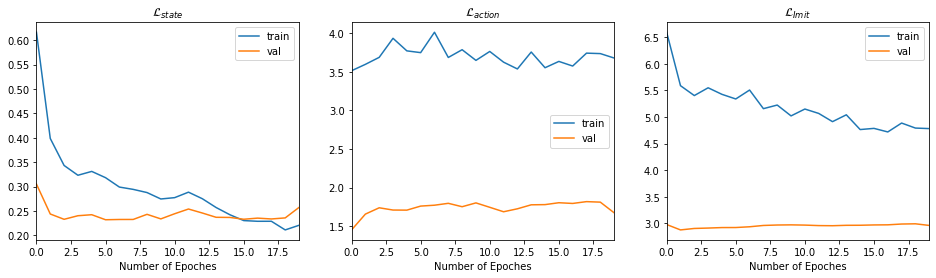

In [19]:
filePath = "{}/".format(results_dir)
lam = 5 
imit_loss = pd.read_pickle(filePath+"Imit_loss.pkl")

fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("$\mathcal{L}_{state}$")
plt.plot(imit_loss["train_state_loss"], label="train")
plt.plot(imit_loss["val_state_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

plt.subplot(1,3,2)
plt.title("$\mathcal{L}_{action}$")
plt.plot(imit_loss["train_action_loss"], label="train")
plt.plot(imit_loss["val_action_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

plt.subplot(1,3,3)
plt.title("$\mathcal{L}_{Imit}$")
plt.plot(lam* imit_loss["train_state_loss"]+ imit_loss["train_action_loss"], label="train")
plt.plot(lam* imit_loss["val_state_loss"]+imit_loss["val_action_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

In [21]:
# Selected Epoch
epoch = 16
imit_record = pd.read_pickle(filePath+"Imit_{}.pkl".format(epoch))

imit_record["Hour"] = pd.Series([time.hour for time in imit_record.index], index = imit_record.index)
imit_record["Occupancy Flag"] = (imit_record["Hour"]>=8) & (imit_record["Hour"]< 18)
imit_record["Indoor Temp. Setpoint"] = pd.Series([22.5 if occupied==1 else 12.8 for occupied in imit_record["Occupancy Flag"]], index = imit_record.index)

/Users/Gaby/Documents/uofa/hvac_control/Gnu-RL/hvac_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


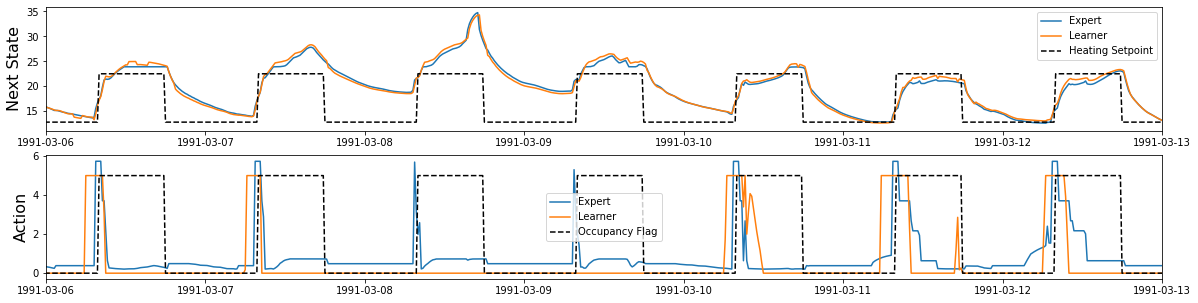

In [23]:
start_time = pd.datetime(year = 1991, month = 3, day = 6)
end_time = start_time + pd.Timedelta(days = 7)

fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(imit_record["Expert nState"], label = "Expert")
plt.plot(imit_record["Learner nState"], label = "Learner")
plt.plot(imit_record["Indoor Temp. Setpoint"], "k--", label = "Heating Setpoint")
plt.ylabel("Next State", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()

plt.subplot(2,1,2)
plt.plot(imit_record["Expert action"], label = "Expert")
plt.plot(imit_record["Learner action"], label = "Learner")
plt.plot(imit_record["Occupancy Flag"]*5, 'k--', label = "Occupancy Flag")
plt.ylabel("Action", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()